# Genral function to extract Gene ontology (GO) and calculated semantic similarity in order to to use GO annotation as feature for mashine learning 

# General code to extract GO from biomart
Output : gene_id_df dataframe containing external_gene_name', 'uniprotswissprot', 'GO_id','and domain of the GO 

This code extract GO from biomart ensembl anotation using python tool pybiomart.

It used last verstion released 2017 for pybiomart .
https://pypi.org/project/pybiomart/#description

(I dont know how this code will be uppdaded to extract the most novel GO in biomart), but since it used host in the code so may included uppdaded


In [2]:
# Libraly 
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from pybiomart import Dataset
from goatools.base import get_godag
from goatools.semsim.termwise.wang import SsWang



In [4]:

# from pybiomart import Dataset

dataset = Dataset(name='hsapiens_gene_ensembl',
                  host='http://www.ensembl.org')


# Gene name used because ensabel id has diffrent transcript for the same gene which can led to confution of GO mapping 
gene_id_df = dataset.query(attributes=['external_gene_name', 'uniprotswissprot', 'go_id','namespace_1003'])
gene_id_df

,Gene name,UniProtKB/Swiss-Prot ID,GO term accession,GO domain
0,MT-ND1,P03886,GO:0016020,cellular_component
1,MT-ND1,P03886,GO:0005739,cellular_component
2,MT-ND1,P03886,GO:0005515,molecular_function
3,MT-ND1,P03886,GO:0031966,cellular_component
4,MT-ND1,P03886,GO:0005743,cellular_component
...,...,...,...,...
397601,STMN1,NaN,GO:0031110,biological_process
397602,STMN1,NaN,GO:0005737,cellular_component
397603,STMN1,NaN,GO:0005829,cellular_component
397604,STMN1,NaN,GO:0005856,cellular_component


# Separate gene names by GO annotation domain :biological process(BP), molecular function(MF), cellular component(CC).

Input:
gene_id_df: A DataFrame containing information on genes with the columns:
Gene name: The name or identifier of the gene
GO term accession: The unique identifier for the GO term associated with the gene
GO domain: The domain category of the GO term (e.g., Biological Process, Molecular Function, or Cellular Component), as retrieved from BioMart for human genes.

Output:
go_terms_dict: A dictionary that categorizes each gene's GO terms by their functional domain.
Structure: Each domain (BP, MF, or CC) has a sub-dictionary where:
Each gene name is a key.
Each key maps to a list of associated GO term IDs for that domain.
This structure allows easy access to domain-specific GO annotations for each gene.

Dictionary Structure:
The go_terms_dict dictionary is organized to store GO terms based on the three primary domains of the Gene Ontology:
BP: Biological Process
MF: Molecular Function
CC: Cellular Component

Description:
The code takes the gene_id_df DataFrame, which contains columns for Gene name, GO term accession, and GO domain, and processes it as follows:
It iterates over each row in gene_id_df.
For each row:
Retrieves the values for gene_name, go_id (GO term accession), and go_domain (GO domain).
Based on the domain specified in go_domain, it:
Adds the GO term ID (go_id) under the appropriate domain category (BP, MF, or CC) in go_terms_dict.
Ensures each gene's domain-specific list of GO terms is appended with new GO terms as they appear.





In [16]:
# Initialize dictionaries to hold GO terms categorized by their domain
go_terms_dict = {
    'BP': {},
    'MF': {},
    'CC': {}
}

# Populate the dictionaries with GO terms based on their domain
for index, row in gene_id_df.iterrows():
    gene_name = row['Gene name']
    go_id = row['GO term accession']
    go_domain = row['GO domain']
    
   
     # Add GO term to the appropriate category dictionary
    if go_domain == 'biological_process':
        if gene_name not in go_terms_dict['BP']:
            go_terms_dict['BP'][gene_name] = []
        go_terms_dict['BP'][gene_name].append(go_id)
    elif go_domain == 'molecular_function':
        if gene_name not in go_terms_dict['MF']:
            go_terms_dict['MF'][gene_name] = []
        go_terms_dict['MF'][gene_name].append(go_id)
    elif go_domain == 'cellular_component':
        if gene_name not in go_terms_dict['CC']:
            go_terms_dict['CC'][gene_name] = []
        go_terms_dict['CC'][gene_name].append(go_id)




# Function to open your desirabe pair gene column for GO semantic simillirty calculation.

Input:
file_path: The path to the file containing gene pairs. The file should contain two columns with gene names.

gene1_col: The column name in the file for the first gene (e.g., "Gene1").
gene2_col: The column name in the file for the second gene (e.g., "Gene2").
Note: Gene names should correspond to protein names to ensure accurate GO term retrieval.

go_terms_dict: A dictionary that contains GO terms for human genes, categorized by Gene Ontology domains:
BP: Biological Process
MF: Molecular Function
CC: Cellular Component
Each domain contains a dictionary where keys are gene names, and values are lists of associated GO term IDs.

Output:
comparison_df: A DataFrame where each row represents a gene pair. For each gene in the pair:
GO terms are organized and displayed by domain (BP, MF, and CC).



In [5]:

# Function to get all GO terms for Gene1 and Gene2
def get_all_go_terms(gene1, gene2, go_terms_dict):
    """
    Retrieves all GO terms for two specified genes.
     
    Libraly :
    pandas 

    Parameters:
        gene1 (str): The name of the first gene.
        gene2 (str): The name of the second gene.
        go_terms_dict (dict): Dictionary containing GO terms categorized by domain (BP, MF, CC).

    Returns:
        dict: A dictionary with GO terms organized by domain for each gene.
    """
    # Retrieve GO terms for Gene1
    go_terms_gene1 = {
        'BP': set(go_terms_dict['BP'].get(gene1, [])),
        'MF': set(go_terms_dict['MF'].get(gene1, [])),
        'CC': set(go_terms_dict['CC'].get(gene1, []))
    }
    
    # Retrieve GO terms for Gene2
    go_terms_gene2 = {
        'BP': set(go_terms_dict['BP'].get(gene2, [])),
        'MF': set(go_terms_dict['MF'].get(gene2, [])),
        'CC': set(go_terms_dict['CC'].get(gene2, []))
    }
    
    # Combine GO terms into a single dictionary for better representation
    all_go_terms = {
        'Gene1': go_terms_gene1,
        'Gene2': go_terms_gene2
    }
    
    return all_go_terms

# Main function to process gene pairs and create the comparison DataFrame
def process_gene_pairs(file_path, gene1_col, gene2_col, go_terms_dict):
    """
    Processes gene pairs from a file and retrieves GO terms for each pair.

    Parameters:
        file_path (str): The path to the file containing gene pairs.
        gene1_col (str): The name of the first gene column.
        gene2_col (str): The name of the second gene column.
        go_terms_dict (dict): Dictionary containing GO terms categorized by domain (BP, MF, CC).

    Returns:
        pd.DataFrame: DataFrame with GO terms for each gene in the pairs.
    """
    # Load the data
    df = pd.read_csv(file_path, sep='\t')
    
    # Store the results
    results = []
    
    # Iterate through each gene pair
    for index, row in df.iterrows():
        gene1 = row[gene1_col]
        gene2 = row[gene2_col]
        
        # Get GO terms for both genes in the pair
        go_terms = get_all_go_terms(gene1, gene2, go_terms_dict)
        
        # Append results for the DataFrame
        results.append({
            'Gene1': gene1,
            'Gene1 GO Terms': go_terms['Gene1'],
            'Gene2': gene2,
            'Gene2 GO Terms': go_terms['Gene2']
        })
    
    # Convert the results to a DataFrame for easy visualization
    comparison_df = pd.DataFrame(results)
    return comparison_df

# Usage example inzolia libraly 
file_path = "/home/user/Desktop/paralog_pairs.txt"
gene1_col = 'Gene1'
gene2_col = 'Gene2'

# Call the function to process gene pairs and retrieve GO terms
comparison_df = process_gene_pairs(file_path, gene1_col, gene2_col, go_terms_dict)

# Display the results
print("\nAll GO terms for each gene:\n", comparison_df)



All GO terms for each gene:
        Gene1                                     Gene1 GO Terms   Gene2  \
0       ACTB  {'BP': {'GO:0070527', 'GO:2000779', 'GO:190024...   ACTG1   
1      ACTG1  {'BP': {'GO:0071346', 'GO:1902396', 'GO:005149...    ACTB   
2      EOLA1  {'BP': {'GO:0010468', 'GO:0032675'}, 'MF': {'G...   EOLA2   
3      EOLA2         {'BP': {}, 'MF': {}, 'CC': {'GO:0005739'}}   EOLA1   
4     RABL2A  {'BP': {'GO:0017157', 'GO:0006886'}, 'MF': {'G...  RABL2B   
...      ...                                                ...     ...   
8773  ZBTB26  {'BP': {'GO:0001817', 'GO:0000122', 'GO:000815...  ZBTB12   
8774   ZNF41  {'BP': {'GO:0006357', 'GO:0006355'}, 'MF': {'G...  ZNF517   
8775  ZNF517  {'BP': {'GO:0006357', 'GO:0006355'}, 'MF': {'G...   ZNF41   
8776  PTDSS1  {'BP': {'GO:0006659', 'GO:0008654'}, 'MF': {'G...  PTDSS2   
8777  PTDSS2  {'BP': {'GO:0006659', 'GO:0008654'}, 'MF': {'G...  PTDSS1   

                                         Gene2 GO Terms  
0     {'BP'

# Create general function to calculate Jaccard similarity somantic similirty between gene pairs 


## Steps to Calculate Jaccard Similarity
Create Sets of GO Terms: Convert the lists of GO terms for each entity (e.g., two genes) into sets, 
Calculate the Intersection and Union:
Intersection: Count the common GO terms in both sets.
Union: Count all unique GO terms across both sets.
Compute Jaccard Similarity:
commun gene (Intersection)/ all GO term for both protein (Union)

Input : data frame comparison_df containin GO terms that organized and displayed by domain (BP, MF, and CC).

Output : Data frame containg gene pair and the value of jaccard_similarity calculated somantic similirty between gene pairs 

In [6]:

# Define the Jaccard similarity function
def jaccard_similarity(set1, set2):
    """Calculate Jaccard similarity between two sets."""
    intersection = set1.intersection(set2)
    union = set1.union(set2)
    return len(intersection) / len(union) if union else 0

def calculate_jaccard_similarity(go_data):
    """
    Libraly needed : 
    pandas
    itertools
    Calculate the Jaccard similarity for gene pairs based on their GO terms.

    Parameters:
    - go_data: DataFrame with columns: 'Gene1', 'Gene1 GO Terms', 'Gene2', 'Gene2 GO Terms'

    Returns:
    - results_df: DataFrame with Jaccard similarities for each gene pair.
    """
    
    # Initialize a list to store results
    results = []

    # Process each row in the DataFrame
    for index, row in go_data.iterrows():
        gene1 = row['Gene1']
        gene2 = row['Gene2']

        # Extract GO terms for each category
        go_terms_gene1_bp = row['Gene1 GO Terms'].get('BP', set())
        go_terms_gene1_mf = row['Gene1 GO Terms'].get('MF', set())
        go_terms_gene1_cc = row['Gene1 GO Terms'].get('CC', set())

        go_terms_gene2_bp = row['Gene2 GO Terms'].get('BP', set())
        go_terms_gene2_mf = row['Gene2 GO Terms'].get('MF', set())
        go_terms_gene2_cc = row['Gene2 GO Terms'].get('CC', set())

        # Calculate Jaccard similarities for each category
        jaccard_bp_similarity = jaccard_similarity(go_terms_gene1_bp, go_terms_gene2_bp)
        jaccard_mf_similarity = jaccard_similarity(go_terms_gene1_mf, go_terms_gene2_mf)
        jaccard_cc_similarity = jaccard_similarity(go_terms_gene1_cc, go_terms_gene2_cc)

        # Append results
        results.append({
            "Gene1": gene1,
            "Gene2": gene2,
            "Jaccard BP Similarity": jaccard_bp_similarity,
            "Jaccard MF Similarity": jaccard_mf_similarity,
            "Jaccard CC Similarity": jaccard_cc_similarity,
        })

    # Create a DataFrame for results
    results_df = pd.DataFrame(results)

    return results_df

# Exampel usage for inzolia library for jaccard_similarity

results_js = calculate_jaccard_similarity(comparison_df)

results_js

,Gene1,Gene2,Jaccard BP Similarity,Jaccard MF Similarity,Jaccard CC Similarity
0,ACTB,ACTG1,0.145833,0.466667,0.408163
1,ACTG1,ACTB,0.145833,0.466667,0.408163
2,EOLA1,EOLA2,0.000000,0.000000,1.000000
3,EOLA2,EOLA1,0.000000,0.000000,1.000000
4,RABL2A,RABL2B,0.400000,1.000000,0.142857
...,...,...,...,...,...
8773,ZBTB26,ZBTB12,0.750000,0.857143,0.666667
8774,ZNF41,ZNF517,1.000000,0.500000,1.000000
8775,ZNF517,ZNF41,1.000000,0.500000,1.000000
8776,PTDSS1,PTDSS2,1.000000,0.500000,1.000000


# Calculate the Basic Statistics of Calculated Semantic Jaccard Similarity and Visualize the Distribution

Input:

A DataFrame containing GO term similarity calculations.
A list of column names representing the similarity scores.

Output:

Histogram: Visualizes the distribution of similarity scores.
Box Plot: Illustrates the spread of the data, including median and quartiles.
Density Plot: Provides a smoothed curve showing the distribution of similarity scores.
Statistics: Outputs descriptive statistics from the describe() function for each similarity column.



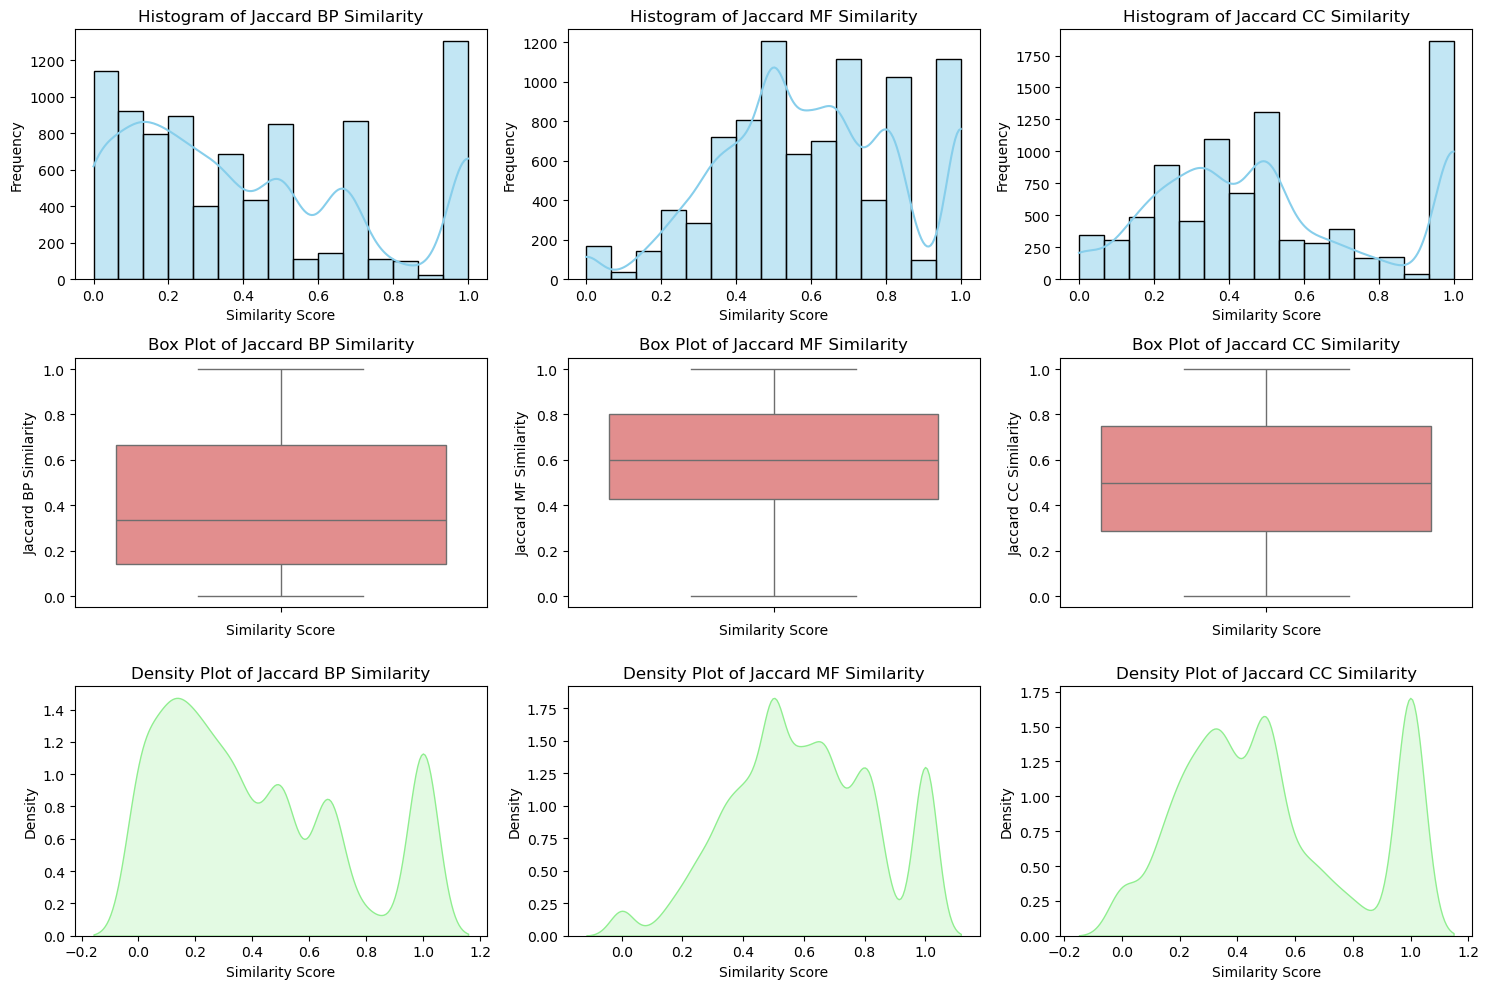


Jaccard BP Similarity Statistics:
count    8778.000000
mean        0.411933
std         0.323897
min         0.000000
25%         0.142857
50%         0.333333
75%         0.666667
max         1.000000
Name: Jaccard BP Similarity, dtype: float64

Jaccard MF Similarity Statistics:
count    8778.000000
mean        0.599268
std         0.239669
min         0.000000
25%         0.428571
50%         0.600000
75%         0.800000
max         1.000000
Name: Jaccard MF Similarity, dtype: float64

Jaccard CC Similarity Statistics:
count    8778.000000
mean        0.516579
std         0.305340
min         0.000000
25%         0.285714
50%         0.500000
75%         0.750000
max         1.000000
Name: Jaccard CC Similarity, dtype: float64


In [7]:
def calculate_and_visualize_similarity_stats(df, similarity_columns):
    """
    Calculate and visualize basic statistics for each similarity column.

    Libraly needed :
    pandas
    matplotlib.pyplot
    seaborn

    Parameters:
        df (pd.DataFrame): The DataFrame containing similarity scores for various domains.
        similarity_columns (list): List of column names with similarity scores.

    Returns:
        dict: A dictionary containing descriptive statistics for each similarity column.
    """
    # Dictionary to hold the statistics for each similarity column
    stats_dict = {}
    
    # Set up the visualization layout
    plt.figure(figsize=(15, 10))
    
    for i, col in enumerate(similarity_columns, 1):
        if col in df.columns:
            # Calculate statistics and store them
            stats_dict[col] = df[col].describe()
            
            # Plot histogram
            plt.subplot(3, len(similarity_columns), i)
            sns.histplot(df[col], kde=True, bins=15, color="skyblue", fill=True)  
            plt.title(f"Histogram of {col}")
            plt.xlabel("Similarity Score")
            plt.ylabel("Frequency")
            
            # Plot boxplot
            plt.subplot(3, len(similarity_columns), i + len(similarity_columns))
            sns.boxplot(y=df[col], color="lightcoral")
            plt.title(f"Box Plot of {col}")
            plt.xlabel("Similarity Score")

            # Plot density plot 
            plt.subplot(3, len(similarity_columns), i + 2 * len(similarity_columns))
            sns.kdeplot(df[col], fill=True, color="lightgreen")  
            plt.title(f"Density Plot of {col}")
            plt.xlabel("Similarity Score")
    
    plt.tight_layout()
    plt.show()
    
    return stats_dict

# Usage of the function 

similarity_columns = ['Jaccard BP Similarity', 'Jaccard MF Similarity', 'Jaccard CC Similarity']
stats = calculate_and_visualize_similarity_stats(results_js, similarity_columns)

# Display the calculated statistics
for domain, stat in stats.items():
    print(f"\n{domain} Statistics:")
    print(stat)


# Create general function for GO term calculation using Wang simility calculation.

 It used SsWang funcion from goatools tools that calculate GO term relationship based on how closely related they are within the Gene Ontology (GO) tree or Directed Acyclic Graph (DAG).
 The SsWang funcion expanded to loop over and calculated GO terms between two proteins given therir GO anotation.
 It observed an error that some GO term not be recoconized by SsWang function ' **ERROR: GO:0035410 NOT LOADED INTO SsWang '.The code devolped to skipped these GO term.
 New and uppdaded verstion of go-basic.obo which contains GO term relationship downloanded from (https://geneontology.org/docs/download-ontology/) , which are recomended to get the updaded relationship 

Input : data frame comparison_df containin GO terms that organized and displayed by domain (BP, MF, and CC).

Output : Data frame containg gene pair and the value of Wang_similarity calculated somantic similirty between gene pairs 


In [19]:
import pandas as pd
from goatools.base import get_godag
from goatools.semsim.termwise.wang import SsWang
import itertools

def calculate_average_go_similarity(go_data):
    """
    Calculate the average Wang semantic similarity for gene pairs based on their GO terms.

    Library needed : 
    pandas
    goatools.base 
    goatools.semsim.termwise.wang
    itertools
    Parameters:
    - go_data: DataFrame with columns: 'Gene1', 'Gene1 GO Terms', 'Gene2', 'Gene2 GO Terms'

    Returns:
    - results_df: DataFrame with average similarities for each gene pair.
    """

    # Read the GO DAG
    godag = get_godag("/home/user/Desktop/go-basic.obo", optional_attrs={'relationship'})

    # Function to calculate average similarity for a given GO category
    def calculate_average_similarity(go_terms_a, go_terms_b):
        """Calculate average similarity for given GO terms."""
        # Filter out invalid GO terms
        valid_go_terms_a = [go for go in go_terms_a if go in godag]
        valid_go_terms_b = [go for go in go_terms_b if go in godag]

        if not valid_go_terms_a or not valid_go_terms_b:
            return 0  # Return 0 if no valid terms to compare
        # All unique GO terms
        goids = set(valid_go_terms_a).union(set(valid_go_terms_b))  
        
        # Initialize Wang's similarity calculator
        wang = SsWang(goids, godag) 

        # Store similarity scores
        similarity_scores = []  

        # Iterate over all combinations of GO terms from both genes
        for go_a, go_b in itertools.product(valid_go_terms_a, valid_go_terms_b):
            val = wang.get_sim(go_a, go_b)
            similarity_scores.append(val)

        # Calculate and return the average similarity score
        if similarity_scores:
            return sum(similarity_scores) / len(similarity_scores)
        else:
            return 0

    # Initialize a list to store results
    results = []

    # Process each row in the DataFrame
    for index, row in go_data.iterrows():
        gene1 = row['Gene1']
        gene2 = row['Gene2']

        # Extract GO terms for each category
        go_terms_gene1_bp = row['Gene1 GO Terms'].get('BP', set())
        go_terms_gene1_mf = row['Gene1 GO Terms'].get('MF', set())
        go_terms_gene1_cc = row['Gene1 GO Terms'].get('CC', set())

        go_terms_gene2_bp = row['Gene2 GO Terms'].get('BP', set())
        go_terms_gene2_mf = row['Gene2 GO Terms'].get('MF', set())
        go_terms_gene2_cc = row['Gene2 GO Terms'].get('CC', set())

        # Calculate average similarities for each category
        average_bp_similarity = calculate_average_similarity(go_terms_gene1_bp, go_terms_gene2_bp)
        average_mf_similarity = calculate_average_similarity(go_terms_gene1_mf, go_terms_gene2_mf)
        average_cc_similarity = calculate_average_similarity(go_terms_gene1_cc, go_terms_gene2_cc)

        # Append results
        results.append({
            "Gene1": gene1,
            "Gene2": gene2,
            "Average Wang BP Similarity": average_bp_similarity,
            "Average Wang MF Similarity": average_mf_similarity,
            "Average Wang CC Similarity": average_cc_similarity,
        })

    # Create a DataFrame for results
    results_df = pd.DataFrame(results)

    return results_df


# Call the function
results_wg = calculate_average_go_similarity(comparison_df)

#Display the results
print(results_wg)

  EXISTS: /home/user/Desktop/go-basic.obo
/home/user/Desktop/go-basic.obo: fmt(1.2) rel(2024-09-08) 44,296 Terms; optional_attrs(relationship)
       Gene1   Gene2  Average Wang BP Similarity  Average Wang MF Similarity  \
0       ACTB   ACTG1                    0.134660                    0.321431   
1      ACTG1    ACTB                    0.134660                    0.321431   
2      EOLA1   EOLA2                    0.000000                    0.000000   
3      EOLA2   EOLA1                    0.000000                    0.000000   
4     RABL2A  RABL2B                    0.298333                    0.412377   
...      ...     ...                         ...                         ...   
8773  ZBTB26  ZBTB12                    0.460368                    0.384603   
8774   ZNF41  ZNF517                    0.968207                    0.377890   
8775  ZNF517   ZNF41                    0.968207                    0.377890   
8776  PTDSS1  PTDSS2                    0.860658         

# Calculate the Basic Statistics of Calculated Semantic Wang Similarity and Visualize the Distribution

## Why Wang Similarity Might Be Lower than Jaccard Similarity

Feature Weighting: If Wang similarity assigns lower weights to certain shared features compared to how Jaccard treats them (as simple presence), the final value may be lower.

Normalization: The normalization factors used in Wang similarity could significantly reduce the score, especially if there are many features in one set but only a few in the other.

Complex Relationships: Wang similarity often incorporates relationships between features. If the features in one protein are not very similar to those in the other (even if they share some common features), this could lead to a lower similarity score.

Set Composition: If one protein has a very diverse set of features while the other has a more homogenous set, the unique contributions of each may lead to a lower Wang similarity.

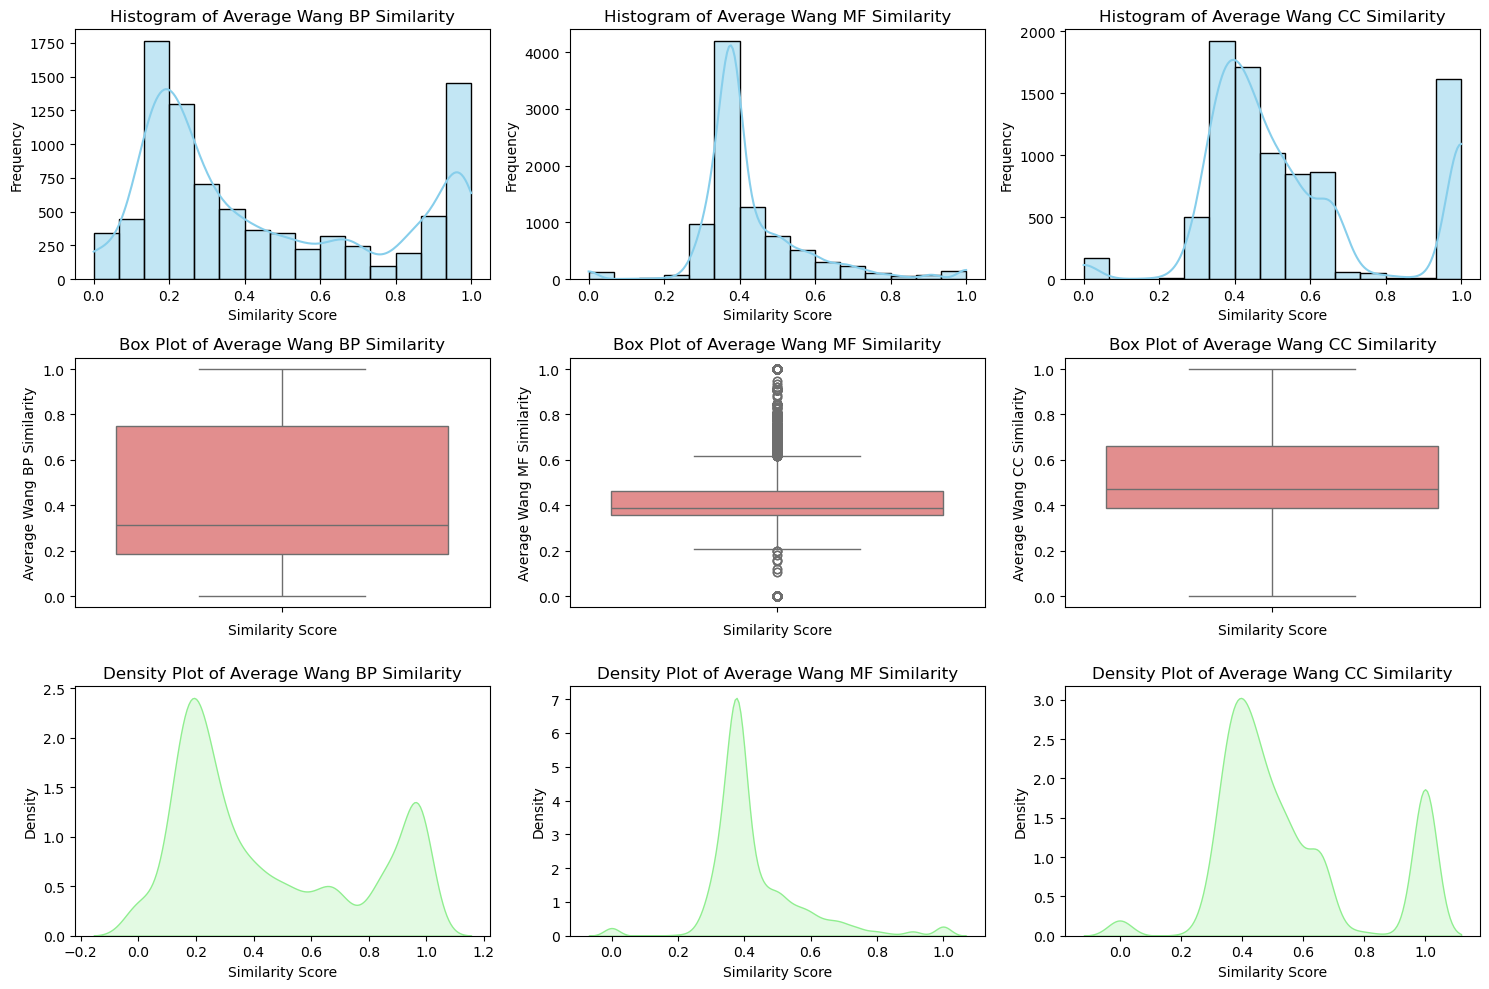


Average Wang BP Similarity Statistics:
count    8778.000000
mean        0.448241
std         0.318372
min         0.000000
25%         0.186842
50%         0.312235
75%         0.748736
max         1.000000
Name: Average Wang BP Similarity, dtype: float64

Average Wang MF Similarity Statistics:
count    8778.000000
mean        0.427521
std         0.142099
min         0.000000
25%         0.358696
50%         0.388164
75%         0.461521
max         1.000000
Name: Average Wang MF Similarity, dtype: float64

Average Wang CC Similarity Statistics:
count    8778.000000
mean        0.554196
std         0.241837
min         0.000000
25%         0.387693
50%         0.471249
75%         0.660821
max         1.000000
Name: Average Wang CC Similarity, dtype: float64


In [20]:
# Call the function calculate_and_visualize_similarity_stats
similarity_columns = ['Average Wang BP Similarity', 'Average Wang MF Similarity', 'Average Wang CC Similarity']
stats = calculate_and_visualize_similarity_stats(results_wg, similarity_columns)

# Display the calculated statistics
for domain, stat in stats.items():
    print(f"\n{domain} Statistics:")
    print(stat)


# Function to write somatic similarity in the file 


In [11]:
# open the file 
# File path 1 
file_path1 = "/home/user/Desktop/paralog_pairs.txt"
# open the file 
df1 = pd.read_csv(file_path1, sep='\t')

# Merge the results back into the original dataframe on 'Gene1' and 'Gene2'
merged_js = pd.merge(df1, results_js, on=['Gene1', 'Gene2'], how='left')

# Merge the results back into the original dataframe on 'Gene1' and 'Gene2'
merged_js_wg = pd.merge(merged_js, results_wg, on=['Gene1', 'Gene2'], how='left')

# Check the result
print(merged_js_wg.head())
# Write the merged DataFrame to a text file with tab-separated values
merged_js_wg.to_csv('GO_term_somatic_similarity.txt', sep='\t', index=False)



         ReagentID   Gene1   Gene2    Gene1_ensembl    Gene2_ensembl  \
0     ACTB_ACTG1_1    ACTB   ACTG1  ENSG00000075624  ENSG00000184009   
1     ACTB_ACTG1_2   ACTG1    ACTB  ENSG00000184009  ENSG00000075624   
2    EOLA1_EOLA2_1   EOLA1   EOLA2  ENSG00000197620  ENSG00000197021   
3    EOLA1_EOLA2_2   EOLA2   EOLA1  ENSG00000197021  ENSG00000197620   
4  RABL2A_RABL2B_1  RABL2A  RABL2B  ENSG00000079974  ENSG00000144134   

   Jaccard BP Similarity  Jaccard MF Similarity  Jaccard CC Similarity  \
0               0.145833               0.466667               0.408163   
1               0.145833               0.466667               0.408163   
2               0.000000               0.000000               1.000000   
3               0.000000               0.000000               1.000000   
4               0.400000               1.000000               0.142857   

   Average Wang BP Similarity  Average Wang MF Similarity  \
0                    0.134660                    0.321431   


In [12]:
df1

,ReagentID,Gene1,Gene2,Gene1_ensembl,Gene2_ensembl
0,ACTB_ACTG1_1,ACTB,ACTG1,ENSG00000075624,ENSG00000184009
1,ACTB_ACTG1_2,ACTG1,ACTB,ENSG00000184009,ENSG00000075624
2,EOLA1_EOLA2_1,EOLA1,EOLA2,ENSG00000197620,ENSG00000197021
3,EOLA1_EOLA2_2,EOLA2,EOLA1,ENSG00000197021,ENSG00000197620
4,RABL2A_RABL2B_1,RABL2A,RABL2B,ENSG00000079974,ENSG00000144134
...,...,...,...,...,...
8773,ZBTB12_ZBTB26_2,ZBTB26,ZBTB12,ENSG00000171448,ENSG00000204366
8774,ZNF41_ZNF517_1,ZNF41,ZNF517,ENSG00000147124,ENSG00000197363
8775,ZNF41_ZNF517_2,ZNF517,ZNF41,ENSG00000197363,ENSG00000147124
8776,PTDSS1_PTDSS2_1,PTDSS1,PTDSS2,ENSG00000156471,ENSG00000174915


In [14]:
merged_js_wg

,ReagentID,Gene1,Gene2,Gene1_ensembl,Gene2_ensembl,Jaccard BP Similarity,Jaccard MF Similarity,Jaccard CC Similarity,Average Wang BP Similarity,Average Wang MF Similarity,Average Wang CC Similarity
0,ACTB_ACTG1_1,ACTB,ACTG1,ENSG00000075624,ENSG00000184009,0.145833,0.466667,0.408163,0.134660,0.321431,0.297757
1,ACTB_ACTG1_2,ACTG1,ACTB,ENSG00000184009,ENSG00000075624,0.145833,0.466667,0.408163,0.134660,0.321431,0.297757
2,EOLA1_EOLA2_1,EOLA1,EOLA2,ENSG00000197620,ENSG00000197021,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
3,EOLA1_EOLA2_2,EOLA2,EOLA1,ENSG00000197021,ENSG00000197620,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
4,RABL2A_RABL2B_1,RABL2A,RABL2B,ENSG00000079974,ENSG00000144134,0.400000,1.000000,0.142857,0.298333,0.412377,0.518634
...,...,...,...,...,...,...,...,...,...,...,...
8773,ZBTB12_ZBTB26_2,ZBTB26,ZBTB12,ENSG00000171448,ENSG00000204366,0.750000,0.857143,0.666667,0.460368,0.384603,0.561526
8774,ZNF41_ZNF517_1,ZNF41,ZNF517,ENSG00000147124,ENSG00000197363,1.000000,0.500000,1.000000,0.968207,0.377890,1.000000
8775,ZNF41_ZNF517_2,ZNF517,ZNF41,ENSG00000197363,ENSG00000147124,1.000000,0.500000,1.000000,0.968207,0.377890,1.000000
8776,PTDSS1_PTDSS2_1,PTDSS1,PTDSS2,ENSG00000156471,ENSG00000174915,1.000000,0.500000,1.000000,0.860658,0.704432,0.606017
